# Introduction to Random Forests

Modern machine learning can be distilled down to a couple of key techniques that are of very wide applicability. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

- *Ensembles of decision trees* (i.e. Random Forests and Gradient Boosting Machines), mainly for structured data (such as you might find in a database table at most companies)
- *Multi-layered neural networks learnt with SGD* (i.e. shallow and/or deep learning), mainly for unstructured data (such as audio, vision, and natural language)

In this course we'll be doing a deep dive into random forests, and simple models learnt with SGD. We'll be learning about gradient boosting and deep learning in part 2.

The dataset that we will use for this part of the course is from the "Blue Book for Bulldozers" Kaggle competition, located [here](https://www.kaggle.com/c/bluebook-for-bulldozers). The predictive modelling challenge was to predict the sale price of a heavy piece of machinery at auction based on its usage, equipment type and configuration.The evaluation metric for this competition was the RMSLE (root mean squared log error) between the actual and predicted auction prices.

### Imports

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The last import line allows us to display plotted data within the notebook

In [3]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [4]:
?display

Adding a question mark before a function will tell you what the function does

In [5]:
PATH = "data/bulldozers/"
!ls {PATH}

Train.csv  bulldozers.zip


## The data


Kaggle provides info about some of the fields of our dataset; on the [Kaggle Data info](https://www.kaggle.com/c/bluebook-for-bulldozers/data) page they say the following:

For this competition, we are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012. You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the unique identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

Clarification on new Python 3.6 syntax:

In [6]:
name = 'Snehan'
f'Hello {name}'

'Hello Snehan'

In [7]:
name = 'Snehan'
age = 24
f'Hello {name.upper()}, you are {age}'

'Hello SNEHAN, you are 24'

We shall now read the import the data. Note that 'df' stands for dataframe.

In [8]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory = False,
                    parse_dates = ["saledate"])

In [9]:
df_raw

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401120,6333336,10500,1840702,21439,149,1.0,2005,NaN,NaN,2011-11-02,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401121,6333337,11000,1830472,21439,149,1.0,2005,NaN,NaN,2011-11-02,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401122,6333338,11500,1887659,21439,149,1.0,2005,NaN,NaN,2011-11-02,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
401123,6333341,9000,1903570,21435,149,2.0,2005,NaN,NaN,2011-10-25,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [10]:
?pd.option_context

In [11]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000):
        with pd.option_context("display.max_columns", 1000):
            display(df)

In [12]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [13]:
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [14]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaT,NaT,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaT,NaT,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaT,NaT,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaT,NaT,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaT,NaT,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaT,NaT,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaT,NaT,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaT,NaT,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17,2011-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To avoid overfitting, many academic sources suggest that *Exploratory Data Analysis* should not be undertaken first; however, practical sources suggest doing so. Jeremy suggests the answer lies somewhere in the middle: ML-driven EDA.

As the evaluation metric for this particular project requires the RMSLE between the actual and predicted auction prices, we now take the log of the prices.

In [15]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [16]:
df_raw.SalePrice

0         11.097410
1         10.950807
2          9.210340
3         10.558414
4          9.305651
            ...    
401120     9.259131
401121     9.305651
401122     9.350102
401123     9.104980
401124     8.955448
Name: SalePrice, Length: 401125, dtype: float64

### Creating a Random Forest

There is a difference between methods that predict continuous variables and those that predict categorical/discrete variables. In the case of the former, the ML models are called *Regression* models and in the latter, they are called *Classification* models. 

In [17]:
RandomForestRegressor

sklearn.ensemble.forest.RandomForestRegressor

In [18]:
?RandomForestRegressor

Below, we create an instance of the estimator. We then call `.fit` and pass in our independent variables - the data we want to use for prediction, followed by the dependant vairable. The `.drop` method returns a new dataframe with a list of columns or rows removed; *axis = 1* specifies the removal of a column. Note that `?` returns the documentation where `??` returns the source code.

In [19]:
m = RandomForestRegressor(n_jobs = -1) # -1 allows the estimator to use all the processors
m.fit (df_raw.drop('SalePrice', axis = 1), df_raw.SalePrice)

/home/snehansighat/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: could not convert string to float: 'Low'

The reason behind the error above is that the dataset contains a mix of continuous and categorical variables. When extracting our data, we told the program to parse the information in the 'saledate' column as dates. The datetype therefore is `datetime64` (64 bit) which is not a number! Here we come across our first example of feature engineering.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals.  One should always consider this feature extraction step when working with date-time. Without expanding the date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities, e.g public holidays, events, etc.

In [25]:
df_raw.saledate

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
401120   2011-11-02
401121   2011-11-02
401122   2011-11-02
401123   2011-10-25
401124   2011-10-25
Name: saledate, Length: 401125, dtype: datetime64[ns]

In [26]:
??add_datepart

`add_datepart` converts a column from a dataframe, from datetime64 to many columns containing the information from the date. One has to access attributes such as year from the datetime method using `.dt.attribute`, we can then choose as many attributes as we feel relevant and seperating them out for use.

In [27]:
fld = df_raw.saledate

In [28]:
fld.dt.year

0         2006
1         2004
2         2004
3         2011
4         2009
          ... 
401120    2011
401121    2011
401122    2011
401123    2011
401124    2011
Name: saledate, Length: 401125, dtype: int64

In [29]:
fld.dt.dayofyear

0         320
1          86
2          57
3         139
4         204
         ... 
401120    306
401121    306
401122    306
401123    298
401124    298
Name: saledate, Length: 401125, dtype: int64

In [30]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [31]:
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


As can be seen above, `Saledate` has been removed and replaced by a collection of columns such as `saleYear` and `saleWeek`. We also see below that the *UsageBand* column for example has strings stored as datatypes which turns out to be inefficient and does not provide the numeric coding required for a random forest. We therefore call `train_cats` to convert strings to pandas categories, which works as pandas will continue displaying the text categories, while treating them as numerical data internally; this can be seen using:

In [33]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200


In [34]:
??train_cats

In [20]:
train_cats(df_raw)

In [37]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [38]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered = True, inplace = True)

In [39]:
df_raw.UsageBand.cat.codes

0         2
1         2
2         0
3         0
4         1
         ..
401120   -1
401121   -1
401122   -1
401123   -1
401124   -1
Length: 401125, dtype: int8

In [40]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

The above will add up the number of empty values for each series which we sort by their index and divide by the size of the dataset. We end up with essentially the percentage of missing values for each series.

In [21]:
os.makedirs('tmp', exist_ok = True)
df_raw.to_feather('tmp/bulldozers-raw')

Here we save this file for now so it can we be stored and accessed efficiently and then read from this last format:

In [22]:
df_raw = pd.read_feather('tmp/bulldozers-raw')

So far we have replaced categories with their numeric codes, handled missing continuous values, and split the dependent variable into a separate variable.

In [43]:
??proc_df

In [23]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [45]:
df.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',
       'saleI

In [46]:
df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,3,950,296,...,320,False,False,False,False,False,False,1163635200,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,3,1725,527,...,86,False,False,False,False,False,False,1080259200,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,331,110,...,57,False,False,False,False,False,False,1077753600,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3674,1375,...,139,False,False,False,False,False,False,1305763200,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,2,4208,1529,...,204,False,False,False,False,False,False,1248307200,False,False


Now that our dataset is purely numerical, we can pass it on to a random forest!

In [24]:
m = RandomForestRegressor(n_jobs = -1)
m.fit(df, y)
m.score(df, y)

/home/snehansighat/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9830912215375447

This is our value for the coefficient of determination *R²*, which is essentially the ratio between how good our model is (RMSE) compared to how good the naïve mean model is (RMSE).

Using all our data can lead to __overfitting__ as we have obtained the best accuracy on the training set; this accuracy may not carry over to new data, i.e the test set. A validation set helps diagnose this problem, as we require an independant dataset that was not used to create the model in the first place, which we create below while bearing in mind that we are attempting to somewhat replicate the test set.

In [25]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy() 

# This function returns the first n rows (for the training set) 
# and the last n rows (for the validation set) 

n_valid = 12000 # Same size as Kaggle's test set
n_trn = len(df) - n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn) 

df_raw.shape, raw_train.shape, raw_valid.shape

((401125, 53), (389125, 53), (12000, 53))

In [26]:
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 54), (389125,), (12000, 54))

In [27]:
def rmse(x, y): return math.sqrt(((x - y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    # [training rmse, validation rmse, training set R², validation set R²]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [28]:
m = RandomForestRegressor(n_jobs = -1)
%time m.fit(X_train, y_train)
print_score(m)

/home/snehansighat/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 1s, sys: 797 ms, total: 1min 2s
Wall time: 12.5 s
[0.09041887734682194, 0.2516232598975862, 0.9829135025133834, 0.8869294400049131]


As we can see, our value for *R²* is 0.888 on the validation set, which implies that we are heavily overfitting on the training set, for which the *R²* is 0.983; however the relatively low RMSE of 0.25 tells us that the degree of overfitting is not too bad! 

## Speeding things up

As a rule of thumb, if something takes >10s to run, it is too long for interactive analysis. Therefore, one of the ways we can get things done faster, is by passing a subset to `proc_df` to randomly sample our data; below we resample the training set into the first 20,000 out of a 30,000 subsets. Once we are content with our feature engineering and hyperparameters, we can then pass in the full training set.

In [29]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [30]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

/home/snehansighat/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 2.31 s, sys: 15.6 ms, total: 2.33 s
Wall time: 575 ms
[0.11098472906053243, 0.3571031280195361, 0.9730376434136578, 0.7722621151538562]


When calling `split_vals`, we do not put the result to a validation set. `_` indicates that we are throwing away the return value. We want to keep validation set the same all the time.

## Single estimator

In [31]:
m = RandomForestRegressor(n_estimators = 1, max_depth = 3,
                          bootstrap = False, n_jobs = -1)
m.fit(X_train, y_train)
print_score(m)

[0.5222470174974043, 0.5828195424665357, 0.4029876259908617, 0.39338075352431007]


`bootstrap = False`: random forest randomizes bunch of things, we want to turn that off by this parameter. `max_depth = 3`: ensures a small tree. As we can see, our *R²* has dropped sharply from 0.749 to 0.393 - this is not a very good model, but is one that we can draw!

In [57]:
??draw_tree

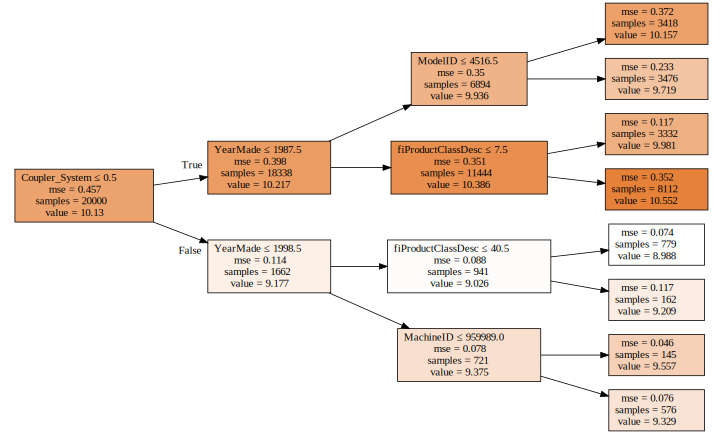

In [32]:
draw_tree(m.estimators_[0], df_trn, precision = 3)

A tree consists of a sequence of binary decisions. The first line indicates the binary split criteria, 
`samples` at the root is 20,000 since that is what we specified when splitting the data and darker color indicates higher `value`.
`value` is the average of the log of the price, and if we built a model where we just used the average all the time, then the mean squared error `mse` would be 0.495.
The best single binary split we can make turns out to be `Coupler_system ≤ 0.5` which will improve `mse` to 0.109 in false path; 0.414 in true path.

We have a single number that represents how good a split at a node is, which is the weighted average of the mean squared errors of the two groups that it creates. We also have a way to find the best split which is to try every variable and to try every possible value of that variable and see which variable and which value gives us a split with the best score. Below we remove the `max_depth = 3` condition to create a deeper tree and see how to affects our results.

In [33]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[5.02429586778808e-17, 0.4856234426316331, 1.0, 0.5788398605983107]


The training *R²* = 1 as each leaf node contains exactly one element, therefore `y_i = f_i` and thus `SSres/SStot = 0`. The validation *R²* comes out improved but not as impressive as we would like! To remedy this, we create a forest of decision trees. In order to do this, we use a statistical technique called __bagging__.

## Bagging

Bagging: what if we created five different models, each of which was only somewhat predictive but the models gave predictions that were not correlated with each other. That would mean that the five models would have profound different insights into the relationships in the data. If you took the average of those five models, you are effectively bringing in the insights from each of them. So this idea of averaging models is a technique for __Ensembling__. Therefore, if we were to create a large number of big, deep and largely overfit trees, but we were to use a different boostrap sample of our data for each tree and we do this multiple times, we end up with massively overfitting trees but overfitting in different ways on different things - the errors on them are random. The average of a number of random errors should theoretically be zero - this is the premise for a random forest. It should be noted however that it is important for the errors, wherever possible, to not be correlated with one another. The research community found that the _more important thing seems to be creating uncorrelated trees rather than more accurate trees_.

In [34]:
m = RandomForestRegressor(n_jobs=-1) # n_estimators = 10 by default
m.fit(X_train, y_train) # we are running this on our subset of data
print_score(m)

/home/snehansighat/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.10980887609996265, 0.34097625799436226, 0.9736059345776394, 0.7923670594152997]


 Lets extract the predictions for each individual tree. Each tree is stored in an attribute called `estimators_` . For each tree, we will call `predict` with our validation set. `np.stack` concatenates them together on a new axis, so the resulting preds has the shape of (10, 12000) (10 trees, 12000 validation set). The mean of 10 predictions for the first data is 9.26, and the actual value is 9.10. As you can see, the mean comes very close.

In [36]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0] # here we extract the first row

(array([9.15905, 8.9872 , 8.9872 , 9.54681, 9.54681, 9.61581, 9.21034, 9.21034, 9.43348, 8.92266]),
 9.261969438295889,
 9.104979856318357)

In [45]:
preds[0:5], preds.shape

(array([[ 9.15905,  9.30565,  9.04782, ...,  9.21034,  9.21034,  9.21034],
        [ 8.9872 ,  8.92266,  9.04782, ...,  9.90349,  9.90349,  9.90349],
        [ 8.9872 ,  9.68034,  9.04782, ...,  9.10498,  9.04782,  9.04782],
        [ 9.54681,  9.6486 ,  9.12696, ..., 10.22194,  9.21034,  9.21034],
        [ 9.54681,  9.30565,  9.10498, ...,  9.68034,  9.54681,  9.54681]]),
 (10, 12000))

In [44]:
??metrics.r2_score

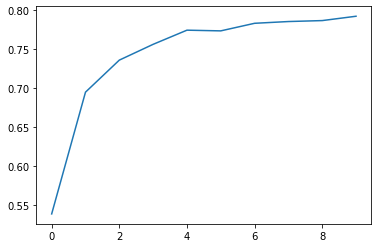

In [40]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis = 0)) for i in range(10)]);

Here is a plot of R² values given first i trees. As we add more trees, R² improves. But it seems as though it has flattened out. Let us see what adding trees does:

In [46]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.1004867432399165, 0.3502270390683378, 0.9778971163361379, 0.7809479514729689]


In [47]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09473567349028779, 0.33394440005625675, 0.9803547079439471, 0.8008426658797401]


In [48]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09243773918045385, 0.342513777893566, 0.9812961924213691, 0.7904903332586505]


As we can see, the effect of adding more trees tapers off over time. This is the first __hyper parameter__ to learn to set — a __number of estimators__;as many as one has time to fit and that actually seems to be helping.
Adding more trees slows it down, but with less trees we can still get the same insights. So when Jeremy builds most of his models, he starts with 20 or 30 trees and at the end of the project or at the end of the day’s work, he will use 1000 trees and run it over night.

## Out-Of-Bag(OOB) score

We may sometimes encounter small datasets and wold not be keen to extract a validation set as it may prevent us from building a good model due to insufficient amounts of data. However, random forests have a very clever trick called out-of-bag (OOB) error which can handle this. The idea is to recognize that when we selected a boostrap sample of data, some data from the original subset did not get used! These unused rows can be passed through the first tree and used as a validation set, this can be done for every tree. This of course ensures a different validation set for each tree. In summary, _the idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was not included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set_.To calculate our prediction, we would average all the trees where that row is not used for training. If you have hundreds of trees, it is very likely that all of the rows are going to appear multiple times in these out-of-bag samples. We can then calculate RMSE, R², etc on these out-of-bag predictions.

In [49]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09519920083891176, 0.3440738559189863, 0.9801619947396509, 0.7885774420525127, 0.8588009299703045]


# Reducing over-fitting

## Subsampling

Instead of having our models train with a different subset of the subset of 30000 rows, why not choose a different set of 30000 rows each time?  So rather than bootstrapping the entire set of rows, just randomly sample a subset of the data. 

In [50]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice') # we recall entire dataset without subset
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [56]:
len(df_trn), len(X_train)

(401125, 389125)

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [53]:
??set_rf_samples

In [54]:
set_rf_samples(20000) # 20,000 chosen out of 389,125 rows instead of 30,000

In [52]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

/home/snehansighat/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 7.38 s, sys: 1.58 s, total: 8.95 s
Wall time: 4.72 s
[0.23760807920031649, 0.27832054176229065, 0.8820067310699593, 0.8616629544650922, 0.8698119436037921]


Now since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [57]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.22431447671659097, 0.2585891828632497, 0.8948402774265359, 0.8805823057138038, 0.8835703869371999]


 After using 40 estimators, we get an increased R² score of 0.894. __Note__: The `set_rf_samples` is a custom function. So OOB score needs to be turned off when using `set_rf_samples` as they are not compatible. `reset_rf_samples()` will turn it back to the way it was.

__Most people run all of their models on all of the data all of the time using their best possible parameters which is just pointless. If we are trying to find out which feature is important and how they are related to each other, having that 4th decimal place of accuracy is not going to change any of our insights at all. Doing most of our models on a large enough sample size that your accuracy is reasonable (within a reasonable distance of the best accuracy you can get) is preferred and so is taking a small number of seconds to train so that we can interactively do our analysis.__

## Tree-building parameters

In [58]:
reset_rf_samples()

In [59]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07860544177551845, 0.2383627158367183, 0.9870866164123646, 0.8985330458150809, 0.9081900327287517]


Here our OOB-score is higher than the R² on our validation set. This is because our validation set is a different time period whereas OOB samples are random. It is much harder to predict a different time period.

### min_samples_leaf

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [60]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11951930446788679, 0.2333306274171572, 0.970145421749807, 0.90277197327749, 0.9082379694959429]


The numbers that work well are 1, 3, 5, 10, 25, but it is relative to our overall dataset size. By using 3 instead of 1, the validation R² improved from 0.899 to 0.902.

### max_features


The less correlated our trees are with each other, the better! With this in mind, in addition to taking a subset of rows at every single split point, _we take a different subset of columns_. If one column is much better than all  the other columns at being predicitive, then every tree we build would always start with that column. There may however be some interaction of variables where that interaction is more important than the individual column; if every tree splits on the same column, we get reduced variation in those trees. 

For row sampling, each new tree is based on a random set of rows, for column sampling, every individual binary split, we choose from a different subset of columns. 0.5 means randomly choosing half of them. Jeremy suggests that the numbers that work well tend to be 1, 0.5, log2 and sqrt.

In [61]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.12644770850290665, 0.22892894081071113, 0.9665838237469917, 0.9064057061813023, 0.9106219082472216]


A validation RMSE of 0.2289 would get us into the top 20 on the competition leaderboard! 